# Question word prediction

> Group 12: Tristan Perrot & Romain Darous

Task is to train and evaluate a QWP model using any available QA-corpus, for instance, the [SQuAD corpus](https://rajpurkar.github.io/SQuAD-explorer/).


In [1]:
import json
import math
import os

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")
device

NVIDIA H100 80GB HBM3 MIG 1g.10gb


device(type='cuda')

## Data


In [3]:
data_dir = 'data'

In [4]:
if data_dir not in os.listdir():
    os.mkdir(data_dir)

if "squad_train.json" not in os.listdir(data_dir):
    # Download data at https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
    res = requests.get(
        "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json")
    data = json.loads(res.text)

    # Save data to file
    with open(data_dir + "/squad_train.json", "w") as f:
        json.dump(data, f)

with open(data_dir + "/squad_train.json", "r") as f:
    data = json.load(f)

# Extract answer text and question text
answers = []
questions = []
for article in data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                continue
            answers.append(qa["answers"][0]["text"])
            questions.append(qa["question"])

print("Number of questions:", len(questions))

# Print some examples
for i in range(5):
    print()
    print("Question:", questions[i])
    print("Answer:", answers[i])

Number of questions: 86821

Question: When did Beyonce start becoming popular?
Answer: in the late 1990s

Question: What areas did Beyonce compete in when she was growing up?
Answer: singing and dancing

Question: When did Beyonce leave Destiny's Child and become a solo singer?
Answer: 2003

Question: In what city and state did Beyonce  grow up? 
Answer: Houston, Texas

Question: In which decade did Beyonce become famous?
Answer: late 1990s


In [5]:
# Tokenize questions
tokenized_questions = [nltk.word_tokenize(q) for q in questions]

# Tokenize answers
tokenized_answers = [nltk.word_tokenize(a) for a in answers]

for i in range(5):
    print()
    print("Question:", tokenized_questions[i])
    print("Answer:", tokenized_answers[i])


Question: ['When', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?']
Answer: ['in', 'the', 'late', '1990s']

Question: ['What', 'areas', 'did', 'Beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?']
Answer: ['singing', 'and', 'dancing']

Question: ['When', 'did', 'Beyonce', 'leave', 'Destiny', "'s", 'Child', 'and', 'become', 'a', 'solo', 'singer', '?']
Answer: ['2003']

Question: ['In', 'what', 'city', 'and', 'state', 'did', 'Beyonce', 'grow', 'up', '?']
Answer: ['Houston', ',', 'Texas']

Question: ['In', 'which', 'decade', 'did', 'Beyonce', 'become', 'famous', '?']
Answer: ['late', '1990s']


In [6]:
# Merge questions and answers
merged = [q + a for q, a in zip(tokenized_questions, tokenized_answers)]

for i in range(5):
    print()
    print("Merged:", merged[i])


Merged: ['When', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?', 'in', 'the', 'late', '1990s']

Merged: ['What', 'areas', 'did', 'Beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?', 'singing', 'and', 'dancing']

Merged: ['When', 'did', 'Beyonce', 'leave', 'Destiny', "'s", 'Child', 'and', 'become', 'a', 'solo', 'singer', '?', '2003']

Merged: ['In', 'what', 'city', 'and', 'state', 'did', 'Beyonce', 'grow', 'up', '?', 'Houston', ',', 'Texas']

Merged: ['In', 'which', 'decade', 'did', 'Beyonce', 'become', 'famous', '?', 'late', '1990s']


In [7]:
# Create vocabulary
vocab = set()
for m in merged:
    vocab.update(m)

vocab = list(vocab)

# Add "<qw>" to vocabulary
vocab.append("<qw>")
vocab.append("<pad>")
vocab.append("<eos>")

words_to_pred = [
    'What',
    'When',
    'Where',
    'Who',
    'Whom',
    'Whose',
    'Which',
    'How',
    'Whether',
    'Why',
    'In what',
    'In which',
    'How much',
    'How many',
]

# Add to vocabulary
vocab.extend(words_to_pred)

# Create word to index and index to word mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

In [8]:
words_to_hide = 1

hidden_merged = []

for m in merged:
    hidden = m.copy()
    hidden[:words_to_hide] = ["<qw>"] * words_to_hide
    hidden_merged.append(hidden)

for i in range(5):
    print()
    print("Merged:", merged[i])
    print("Hidden:", hidden_merged[i])

interr_words = set()

for questions in merged:
    interr_words.update(questions[:words_to_hide])

print()
print(interr_words)
print(len(interr_words))


Merged: ['When', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?', 'in', 'the', 'late', '1990s']
Hidden: ['<qw>', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?', 'in', 'the', 'late', '1990s']

Merged: ['What', 'areas', 'did', 'Beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?', 'singing', 'and', 'dancing']
Hidden: ['<qw>', 'areas', 'did', 'Beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?', 'singing', 'and', 'dancing']

Merged: ['When', 'did', 'Beyonce', 'leave', 'Destiny', "'s", 'Child', 'and', 'become', 'a', 'solo', 'singer', '?', '2003']
Hidden: ['<qw>', 'did', 'Beyonce', 'leave', 'Destiny', "'s", 'Child', 'and', 'become', 'a', 'solo', 'singer', '?', '2003']

Merged: ['In', 'what', 'city', 'and', 'state', 'did', 'Beyonce', 'grow', 'up', '?', 'Houston', ',', 'Texas']
Hidden: ['<qw>', 'what', 'city', 'and', 'state', 'did', 'Beyonce', 'grow', 'up', '?', 'Houston', ',', 'Texas']

Merged: ['In', 'which', 'decade', 'did', 'Beyonce', 'beco

In [9]:
restricted_merged = []
restricted_hidden_merged = []
words_pred = []

for question in merged:
    if question[0] in words_to_pred:
        restricted_merged.append(question)
        restricted_hidden_merged.append(["<qw>"] + question[1:])
        words_pred.append(question[0])
    if " ".join(question[:2]) in words_to_pred:
        restricted_merged.append(question)
        restricted_hidden_merged.append(["<qw>"] + question[2:])
        words_pred.append(" ".join(question[:2]))

for i in range(5):
    random_idx = torch.randint(0, len(restricted_merged), (1,)).item()
    print("Merged:", restricted_merged[random_idx])
    print("Hidden merged:", restricted_hidden_merged[random_idx])
    print("Word to predict:", words_pred[random_idx])
    print()

print("Len of restricted merged:", len(restricted_merged))

Merged: ['Who', 'bought', 'Seagram', 'in', 'June', '2000', '?', 'Vivendi']
Hidden merged: ['<qw>', 'bought', 'Seagram', 'in', 'June', '2000', '?', 'Vivendi']
Word to predict: Who

Merged: ['Who', 'approves', 'Detroit', "'s", 'budgets', '?', 'The', 'council']
Hidden merged: ['<qw>', 'approves', 'Detroit', "'s", 'budgets', '?', 'The', 'council']
Word to predict: Who

Merged: ['In', 'what', 'county', 'is', 'the', 'Tan', 'Hill', 'Inn', 'located', '?', 'Yorkshire']
Hidden merged: ['<qw>', 'county', 'is', 'the', 'Tan', 'Hill', 'Inn', 'located', '?', 'Yorkshire']
Word to predict: In what

Merged: ['What', 'are', 'people', 'who', 'study', 'nature', 'called', '?', 'natural', 'philosophers']
Hidden merged: ['<qw>', 'are', 'people', 'who', 'study', 'nature', 'called', '?', 'natural', 'philosophers']
Word to predict: What

Merged: ['What', 'actress', 'starred', 'in', 'Arabian', 'Nights', '?', 'Maria', 'Montez']
Hidden merged: ['<qw>', 'actress', 'starred', 'in', 'Arabian', 'Nights', '?', 'Maria', 

In [10]:
x_words = [merged_question[::-1] for merged_question in restricted_hidden_merged]
y_words = words_pred

for i in range(5):
    print()
    print("X_words:", x_words[i])
    print("Y_words:", y_words[i])


X_words: ['1990s', 'late', 'the', 'in', '?', 'popular', 'becoming', 'start', 'Beyonce', 'did', '<qw>']
Y_words: When

X_words: ['dancing', 'and', 'singing', '?', 'up', 'growing', 'was', 'she', 'when', 'in', 'compete', 'Beyonce', 'did', 'areas', '<qw>']
Y_words: What

X_words: ['2003', '?', 'singer', 'solo', 'a', 'become', 'and', 'Child', "'s", 'Destiny', 'leave', 'Beyonce', 'did', '<qw>']
Y_words: When

X_words: ['Texas', ',', 'Houston', '?', 'up', 'grow', 'Beyonce', 'did', 'state', 'and', 'city', '<qw>']
Y_words: In what

X_words: ['1990s', 'late', '?', 'famous', 'become', 'Beyonce', 'did', 'decade', '<qw>']
Y_words: In which


In [11]:
# Convert words to indices
def words_to_indices(words):
    return [word_to_idx[word] for word in words]

x = [words_to_indices(words) for words in x_words]
y = [words_to_pred.index(word) for word in y_words]

for i in range(5):
    print()
    print("X:", x[i])
    print("Y:", y[i])


X: [21170, 3368, 44767, 47693, 42180, 63066, 20935, 46349, 569, 10205, 67298]
Y: 1

X: [51774, 33195, 49594, 42180, 53691, 41002, 65924, 13497, 39897, 47693, 40425, 569, 10205, 21691, 67298]
Y: 0

X: [66570, 42180, 1378, 58961, 50929, 3732, 33195, 36371, 36249, 18306, 49963, 569, 10205, 67298]
Y: 1

X: [3447, 18950, 28300, 42180, 53691, 55036, 569, 10205, 14697, 33195, 29084, 67298]
Y: 10

X: [21170, 3368, 42180, 38190, 3732, 569, 10205, 60743, 67298]
Y: 11


In [12]:
# Pad sequences
max_len = max([len(words) for words in x])

for i in range(len(x)):
    x[i] += [word_to_idx["<eos>"]] + [word_to_idx["<pad>"]] * (max_len - len(x[i]))

for i in range(5):
    print()
    print("X:", x[i])
    print("Y:", y[i])


X: [21170, 3368, 44767, 47693, 42180, 63066, 20935, 46349, 569, 10205, 67298, 67300, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299]
Y: 1

X: [51774, 33195, 49594, 42180, 53691, 41002, 65924, 13497, 39897, 47693, 40425, 569, 10205, 21691, 67298, 67300, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299, 67299]
Y: 0

X: [66570, 42180, 1378, 58961, 50929, 3732, 33195, 36371, 36249, 18306, 49963, 569, 1020

In [13]:
# Convert to tensors
x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)

In [14]:
# Example of a training pair (x, y) words
i = 3
print("X:", [idx_to_word[idx.item()] for idx in x[i]])
print("Y:", words_to_pred[y[i].argmax().item()])

X: ['Texas', ',', 'Houston', '?', 'up', 'grow', 'Beyonce', 'did', 'state', 'and', 'city', '<qw>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Y: What


## Training

We will now our model to predict the first or the two first words of the question given the rest of the question and the answer. We will use a transformer model to do so.


In [15]:
# Train val test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

print("Train size:", len(x_train))
print("Val size:", len(x_val))
print("Test size:", len(x_test))

Train size: 60373
Val size: 7547
Test size: 7547


In [16]:
class QuestionDataset(Dataset):
    def __init__(self, X, Y, word_to_idx):
        self.X = X
        self.Y = Y
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

dataset_train = QuestionDataset(x_train, y_train, word_to_idx)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = QuestionDataset(x_val, y_val, word_to_idx)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

dataset_test = QuestionDataset(x_test, y_test, word_to_idx)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

### LSTM Model for multi-class classification
The class there are defined in `words_to_pred` list.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.7605, Val Loss: 1.7483
Epoch 2/20, Train Loss: 1.7571, Val Loss: 1.7461
Epoch 3/20, Train Loss: 1.7573, Val Loss: 1.7427
Epoch 4/20, Train Loss: 1.7570, Val Loss: 1.7453
Epoch 5/20, Train Loss: 1.7569, Val Loss: 1.7435
Epoch 6/20, Train Loss: 1.5780, Val Loss: 1.2717
Epoch 7/20, Train Loss: 1.0393, Val Loss: 0.8737
Epoch 8/20, Train Loss: 0.7308, Val Loss: 0.7992
Epoch 9/20, Train Loss: 0.5415, Val Loss: 0.7761
Epoch 10/20, Train Loss: 0.3972, Val Loss: 0.8641
Epoch 11/20, Train Loss: 0.2944, Val Loss: 0.9775
Epoch 12/20, Train Loss: 0.2235, Val Loss: 1.0515
Early stopping at epoch 12


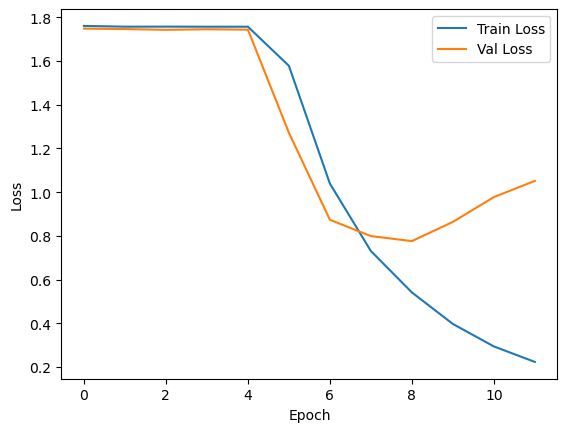

In [29]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = output[:, -1, :]  # Take the last output
        output = self.fc(output)
        return output


# Define the model
input_size = len(vocab)  # Vocabulary size
hidden_size = 128  # Hidden size of LSTM
output_size = len(words_to_pred)  # Number of classes (words to predict)
num_layers = 1  # Number of LSTM layers
model = LSTMClassifier(input_size, hidden_size,
                       output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in trange(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss or best_val_loss > 1:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses


# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

# Predict function
def predict(model, x, idx_to_word, words_to_pred):
    model.eval()
    with torch.no_grad():
        output = model(x)
        pred = output.argmax(dim=1)
        pred_word = words_to_pred[pred.item()]
        x_words = [idx_to_word[idx.item()] for idx in x.squeeze()]
        return x_words, pred_word


# Example of a test prediction
i = 49
x, y = dataset_test[i]

x_words, pred_word = predict(model, x.unsqueeze(
    0).to(device), idx_to_word, words_to_pred)
real_question = x_words[::-1]
# Remove all padding and eos
real_question = [word for word in real_question if word != "<pad>"]
real_question = [word for word in real_question if word != "<eos>"]
print("X:", x_words)
print("Real question:", " ".join(real_question))
print("Y:", words_to_pred[y.item()])
print("Pred:", pred_word)

Test Loss: 1.0672
X: ['ESPN', '?', 'partner', 'broadcast', '2014', "'s", 'League', 'Football', 'Arena', 'the', 'was', '<qw>', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Real question: <qw> was the Arena Football League 's 2014 broadcast partner ? ESPN
Y: Who
Pred: Who


In [40]:
# Predict all test examples and calculate accuracy
correct = 0
total = 0
for x, y in test_loader:
    output = model(x.to(device))
    pred = output.argmax(dim=1)
    correct += (pred == y).sum().item()
    total += y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7326


En vrai c'est pas mal.

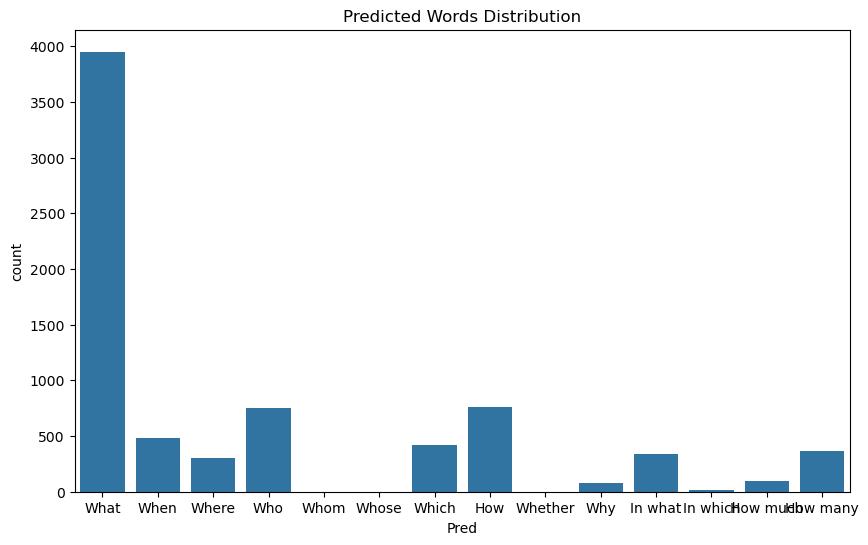

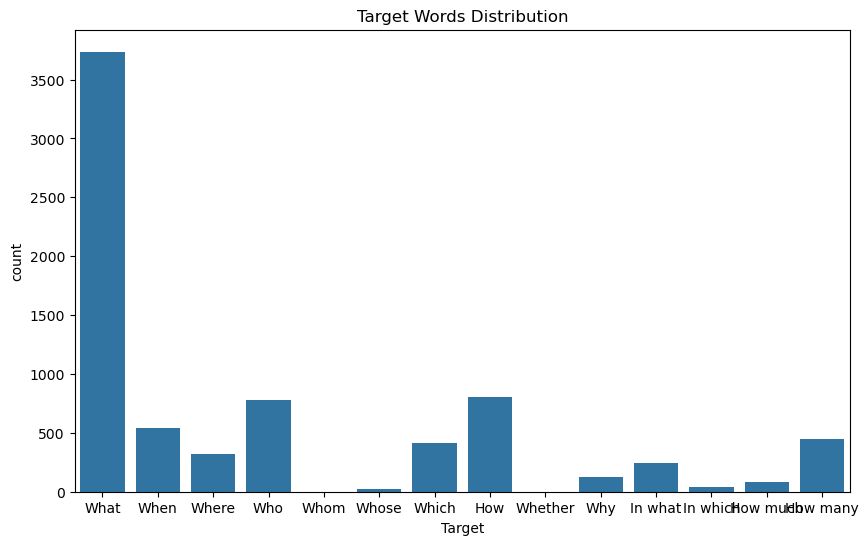

In [41]:
# See the distribution of predicted words compare to the distribution of aimed words
preds = []
targets = []
model.eval()

with torch.no_grad():
    for x, y in test_loader:
        output = model(x.to(device))
        pred = output.argmax(dim=1)
        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

preds = [words_to_pred[pred] for pred in preds]
targets = [words_to_pred[target] for target in targets]

df = pd.DataFrame({"Target": targets, "Pred": preds})

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Pred", order=words_to_pred)
plt.title("Predicted Words Distribution")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Target", order=words_to_pred)
plt.title("Target Words Distribution")
plt.show()

In [47]:
# Matrix of confusion
confusion_matrix = pd.crosstab(df["Target"], df["Pred"])
# Normalize the matrix
confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)
confusion_matrix *= 100
confusion_matrix

Pred,How,How many,How much,In what,In which,What,When,Where,Which,Who,Why
Target,,,,,,,,,,,
How,81.218905,0.124378,0.248756,0.124378,0.000000,12.935323,0.124378,2.736318,0.248756,0.746269,1.492537
How many,0.672646,75.336323,4.260090,2.466368,1.345291,3.587444,0.000000,0.000000,10.313901,2.017937,0.000000
How much,2.325581,4.651163,62.790698,1.162791,0.000000,8.139535,2.325581,8.139535,5.813953,2.325581,2.325581
In what,0.000000,0.833333,0.000000,66.250000,0.833333,26.666667,0.416667,0.416667,4.166667,0.416667,0.000000
In which,0.000000,2.439024,0.000000,68.292683,0.000000,19.512195,2.439024,0.000000,7.317073,0.000000,0.000000
What,1.311212,0.267594,0.267594,3.237891,0.107038,83.034520,0.428151,1.498528,5.351887,3.799839,0.695745
When,0.000000,0.000000,1.291513,0.184502,0.000000,7.933579,77.306273,7.011070,0.184502,5.350554,0.738007
Where,9.090909,0.000000,0.626959,0.313480,0.000000,24.764890,7.210031,46.081505,0.313480,8.150470,3.448276
Whether,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000


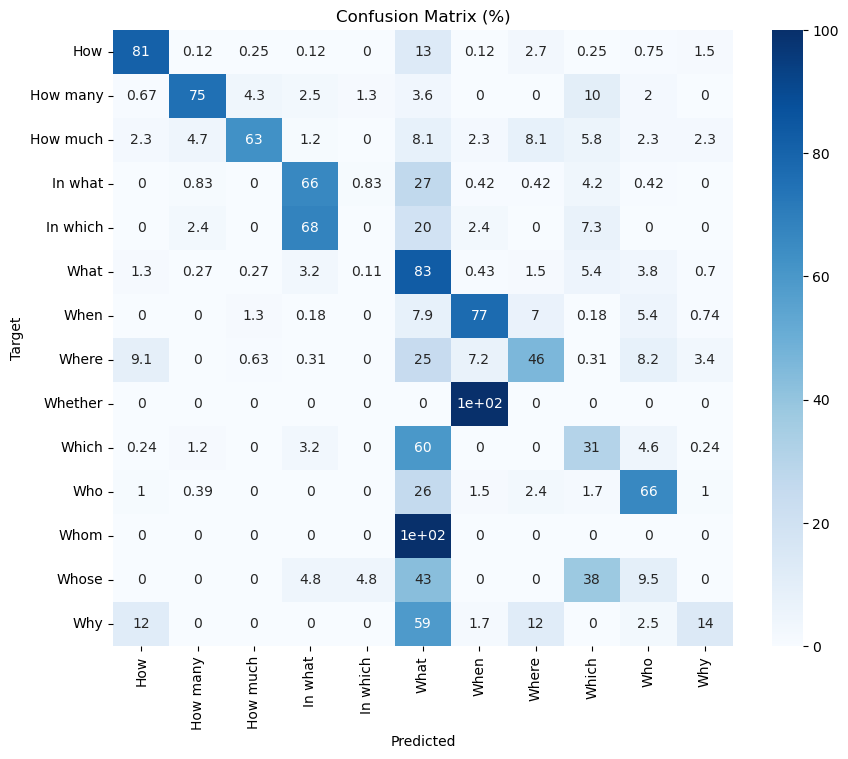

In [49]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Target")
plt.title("Confusion Matrix (%)")
plt.show()